In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import glob
import math
%matplotlib inline

#cv
import cv2
import math
from PIL import Image
import math
from scipy import ndimage
import argparse
import imutils


#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from matplotlib import font_manager, rc
rc('font',family="AppleGothic")
plt.rcParams["font.family"]="AppleGothic" #plt 한글꺠짐
plt.rcParams["font.family"]="Arial" #외국어꺠짐
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 출력 설정
plt.rc('figure', figsize=(10,8))

sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid') #sns 한글깨짐

In [2]:
def show(img):
    #사이즈
    plt.figure(figsize = (10,8))
    #xticks/yticks - 눈금표
    plt.xticks([])
    plt.yticks([])
    #코랩에서 안돌아감 주의
    plt.imshow(img, cmap= 'gray')
    plt.show()

In [3]:
#이미지 수 확인하기
def count_img(path):
    data_path = os.path.join(path, '*g')
    files= glob.glob(data_path)
    img_list=[]
    for f1 in files:
        img = cv2.imread(f1)
        img_list.append(img)
    print('이미지수',len(img_list)) 

In [4]:
#이미지 불러오기
def get_img(path):
    data_path = os.path.join(path, '*g')
    files= glob.glob(data_path)
    img_list=[]
    for f1 in files:
        img = cv2.imread(f1)
        img_list.append(img)
#     print('이미지수',len(img_list))
#     print('show(get_img(list_file[1])[0]) 식으로 이미지 불러와서 img로 저장')
    
    return img_list
    
# data_img = get_img(list_file[2])
# show(img_list[1])

In [5]:
org_img_path ='/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/'

In [6]:
file_list = os.listdir(org_img_path)
file_list.sort()
file_list = file_list[1:]
list_file = []
for i in file_list:
    list_file.append(org_img_path+i)
list_file.sort()
# list_file

### def

In [7]:
#masking, return 까먹지 말기 흑흑 
def get_mask(img):
#     img = cv2.imread(img_path+"/org001.jpg")
    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # #마스크 생성을 위해, 밝기 강조한 Lab으로 이미지 변환 01
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    # show(img)

    # #블러 02
    # #블러의 커널 사이즈가 홀수만 가능하므로 이미지 평균 값을 기준으로 홀수값 만들기
    blur_k = int((img.mean()*0.5)//2)*2+1 
    img = cv2.medianBlur(img, blur_k)
    # show(img)
    # #threshold 적용을 위해 Lab에서 Grayscale로 이미지 변환 03
    img = cv2.cvtColor(img, cv2.COLOR_Lab2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # #이미지 평균값을 기준으로 이진화 04
    ret, img = cv2.threshold(img, img.mean()*1.1, 255, cv2.THRESH_BINARY)

    # # #가장 큰 값의 컨투어로 마스크 만들기 05
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask = cv2.dilate(mask,k)
    return mask

#     show(mask)
    #그 다음에 가지고 있는 이미지 모두 마스크 처리 --> 오래걸림

In [106]:
#masking, return 까먹지 말기 흑흑 
def get_thumbs_mask(img):
    blur_k = int((img.mean()*0.5)//2)*2+1 
    img = cv2.medianBlur(img, blur_k)
    
    # #이미지 평균값을 기준으로 이진화 04
    ret, img = cv2.threshold(img, img.mean(), 255, cv2.THRESH_BINARY)

    # # #가장 큰 값의 컨투어로 마스크 만들기 05
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    thumbs_mask = cv2.dilate(mask,k)
    return thumbs_mask

In [107]:
#img_cropping 
def get_cropped_mask(img, mask):
    """
    마스크를 기준으로 경계선을 찾아 위/왼/오른쪽을 자루는 함수로서
    img = original image
    mask = bit_img
    cropped_img = 원본 이미지에서 마크된 영역을 갖는 부분 반환
    """
    
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = img_.shape
    
    #마스크 기준으로 위/왼/오른쪽 경계선 찾기(숫자로 확인 가능)
    mask_list = mask.tolist()
    
    #테두리가 흰색인 경우를 고려해서, 테두리에서 5% 지점부터 경계점 찾기 시작
    #경계점은 중간 부분(30~70%)에서 검은색(0)을 벗어난 지점을 기준으로 함
    #위쪽
    for y in range(int(height*0.05), height): #마스크이미지에서, 일반 이미지의 5%이상의 지점에서 
    #가로는 30%-70%까지가 0보다 클때 (마스크의 max값이 - 그 범위에 1(흰색)이 있을때)
        if max(mask[y,int(width*0.3):int(width*0.7)]) >0:
        #총 mask 이미지에서, 일반이미지에서 5%더한 값을 뺌
            start_y = y-int(height*0.05)
            break
    
    #왼쪽 start point
    for x in range(int(width*0.05),width):
        if max(mask[x,int(height*0.3):int(height*0.7)]) >0:
            start_x = x-int(width*0.05)
            break

    # #오른쪽, stop, -1,-1(오른쪽에서 왼쪽으로)
    for x in range(int(width*0.95),-1,-1):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            end_x = x+int(width*0.05)
            break

    #경계선 기준으로 이미지와 마스크 자름
    img_ = img_[start_y:,start_x:end_x]
    mask = mask[start_y:,start_x:end_x]

    img = cv2.bitwise_and(img_, mask)
    
    return img

In [116]:
#img_cropping 
def get_thumbs_crop(img, mask):
    
    height, width = img.shape
    
    #마스크 기준으로 위/왼/오른쪽 경계선 찾기(숫자로 확인 가능)
    mask_list = mask.tolist()
    
#     #테두리가 흰색인 경우를 고려해서, 테두리에서 5% 지점부터 경계점 찾기 시작
#     #경계점은 중간 부분(30~70%)에서 검은색(0)을 벗어난 지점을 기준으로 함
#     #위쪽
#     for y in range(int(height*0.05), height): #마스크이미지에서, 일반 이미지의 5%이상의 지점에서 
#     #가로는 30%-70%까지가 0보다 클때 (마스크의 max값이 - 그 범위에 1(흰색)이 있을때)
#         if max(mask[y,int(width*0.3):int(width*0.7)]) >0:
#         #총 mask 이미지에서, 일반이미지에서 5%더한 값을 뺌
#             start_y = y-int(height*0.05)
#             break
    
#     #왼쪽 start point
#     for x in range(int(width*0.05),width):
#         if max(mask[x,int(height*0.3):int(height*0.7)]) >0:
#             start_x = x-int(width*0.05)
#             break

#     # #오른쪽, stop, -1,-1(오른쪽에서 왼쪽으로)
#     for x in range(int(width*0.95),-1,-1):
#         if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
#             end_x = x+int(width*0.05)
#             break

#     #경계선 기준으로 이미지와 마스크 자름
#     img = img[start_y:,start_x:end_x]
#     mask = mask[start_y:,start_x:end_x]

    img = cv2.bitwise_and(img, mask)
    
    return img

In [9]:
def wrist_cut(img):
    height = img.shape[0]
    width = img.shape[1]

    #이미지의 아래에서부터 시작해서 화소 평균이 커지는(밝아지는) 경계선 찾기
    start = int(height*0.95)  #아래 테두리가 밝은 경우를 고려해서 height*0.95부터 시작함
    index = 0
    k = 10 #10개 행씩 평균 구함
    while True:
        pixel_lower = img[start-k*(index+1):start-k*index,:].mean()
        pixel_upper = img[start-k*(index+2):start-k*(index+1),:].mean()
        if pixel_upper - pixel_lower > 0:
            end_y = start-k*(index+1)
            break
        index += 1

    img = img[:end_y]
    return img

In [10]:
def mask_for_center(img):
    blur_k = int((img.mean()*0.5)//2)*2+1 
    img = cv2.medianBlur(img, blur_k)
    
    # #이미지 평균값을 기준으로 이진화 04
    ret, img = cv2.threshold(img, img.mean()*1.1, 255, cv2.THRESH_BINARY)

    # # #가장 큰 값의 컨투어로 마스크 만들기 05
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask = cv2.dilate(mask,k)
    return mask

In [11]:
def get_center(mask):
#     mask = mask_for_center(img)
    res, thresh = cv2.threshold(mask, mask.mean(), 255, cv2.THRESH_BINARY)

    # find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # loop over the contours
    for c in cnts:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    
    return cX, cY

In [31]:
def get_far_list(img):
    #손가락포인트
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(max_cnt, returnPoints = False)
    defects = cv2.convexityDefects(max_cnt, hull)
    
    far_list = []
    for i in range(defects.shape[0]):
        s,e,f,d = defects[i,0]
        start = tuple(max_cnt[s][0])
        end = tuple(max_cnt[e][0])
        far = tuple(max_cnt[f][0])
        far_list.append(far)
        
    return far_list

In [28]:
def get_thumbs_point(far_list):
    far_list.sort(key = lambda x:x[0])
    thX, thY = far_list[-1]
    return thX, thY

In [75]:
def thumbs_rotation(img):
    angle = math.degrees(math.atan2(cY-thY, cX-thX))
    img = ndimage.rotate(img, angle-110)#시계방향
    return img

In [76]:
def rotation_cut(img):
    ret, th = cv2.threshold(img, img.mean(), 255, cv2.THRESH_BINARY)
    th_l = th.tolist()
    cut_index = 0
    if th_l[0][0] == 0 or th_l[0][-1] == 0:
        for i in reversed(range(len(th_l))):
            if th_l[i].count(255) > 0:
                cut_index = i

    img = img[cut_index:]
    return img

In [92]:
def rotation_cut_down(img):
    ret, th = cv2.threshold(img, img.mean(), 255, cv2.THRESH_BINARY)
    th_l = th.tolist()
    cut_index = 0
    if th_l[0][0] == 0 or th_l[0][-1] == 0:
        for i in range(len(th_l)):
            if th_l[i].count(255) > 0:
                cut_index = i

    img = img[:cut_index]
    return img

In [94]:
def rotation_cut_x1(img):
    ret, th = cv2.threshold(img, img.mean(), 255, cv2.THRESH_BINARY)
    th_l = th.tolist()
    cut_index = 0
    if th_l[0][0] == 0 or th_l[0][-1] == 0:
        for i in range(len(th_l)):
            if th_l[i].count(255) > 0:
                cut_index = i

    img = img[:cut_index]
    return img

In [170]:
def get_thumbs_croped(img):
    ret, thresh = cv2.threshold(img, thumbs.mean(), 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_xy = np.array(contours)

    # x의 min과 max 찾기
    x_min, x_max = 0,0
    value = list()
    for i in range(len(contours_xy)):
        for j in range(len(contours_xy[i])):
            value.append(contours_xy[i][j][0][0]) #네번째 괄호가 0일때 x의 값
            x_min = min(value)
            x_max = max(value)
#     print(x_min)
#     print(x_max)

    # y의 min과 max 찾기
    y_min, y_max = 0,0
    value = list()
    for i in range(len(contours_xy)):
        for j in range(len(contours_xy[i])):
            value.append(contours_xy[i][j][0][1]) #네번째 괄호가 0일때 x의 값
            y_min = min(value)
            y_max = max(value)
#     print(y_min)
#     print(y_max)

    # image trim 하기
    x = x_min
    y = y_min
    w = x_max-x_min
    h = y_max-y_min

    img_trim = img[y:y+h, x:x+w]
    
    return img_trim 



In [77]:
def center_img(img):
    imgY, imgX = img.shape[:2]
    imgY = int((imgY)/2)
    imgX = int(imgX/2)
    
    return imgY, imgX

In [84]:
def thumbs_cut(img):
    thumbs_cut =img[thY-300:thY+500, thX-300:thX]
#     middle_cut = cv2.resize(middle_cut,(100,500), cv2.INTER_AREA)
    return thumbs_cut

In [ ]:
def final_cut(img):
    

In [85]:
def img_preprocessing(img):
    mask =get_mask(img)
    black_back = get_cropped_mask(img, mask)
    img = wrist_cut(black_back)
    center_mask = mask_for_center(img)
    return center_mask, img

def get_thumbs_finger_point(center_mask, black_back):
    cX, cY = get_center(center_mask)
    far_list = get_far_list(black_back)
    thX, thY = get_thumbs_point(far_list)
    return cX, cY, thX, thY

def get_imgYX(img):
    rotated_img = thumbs_rotation(img)
    img = rotation_cut(rotated_img)
    imgY, imgX = center_img(img)
    return img, imgY, imgX
    



### test

<ipython-input-170-fad878baaf73>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


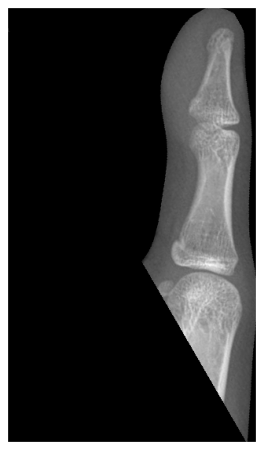

In [174]:
img = get_img(list_file[4])[0]
center_mask, black_back = img_preprocessing(img)
thX, thY = get_thumbs_point(far_list)
img=thumbs_rotation(black_back)
img = rotation_cut(img)
thumbs = thumbs_cut(black_back)
thumbs_fin = get_thumbs_croped(thumbs)
show(thumbs_fin)

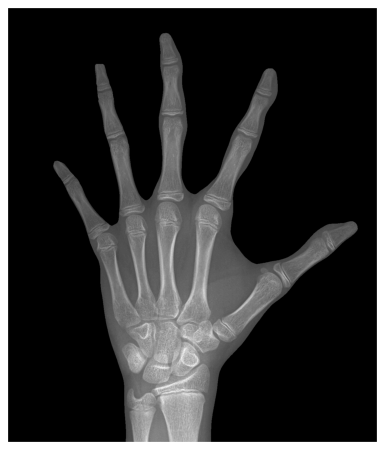

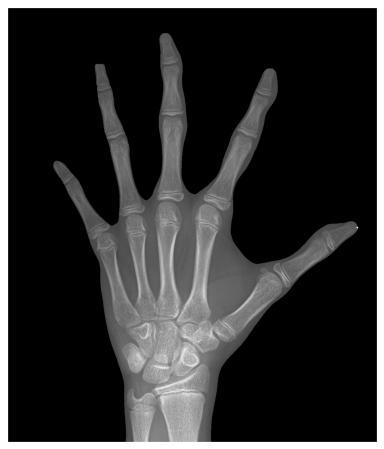

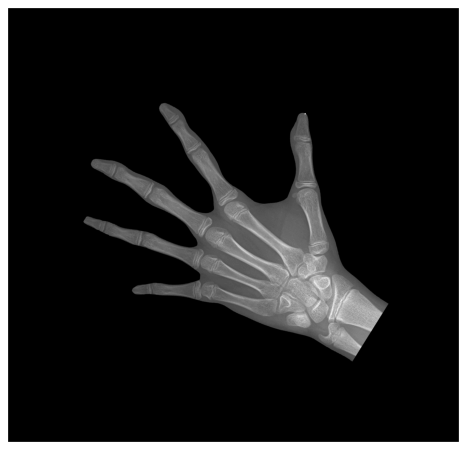

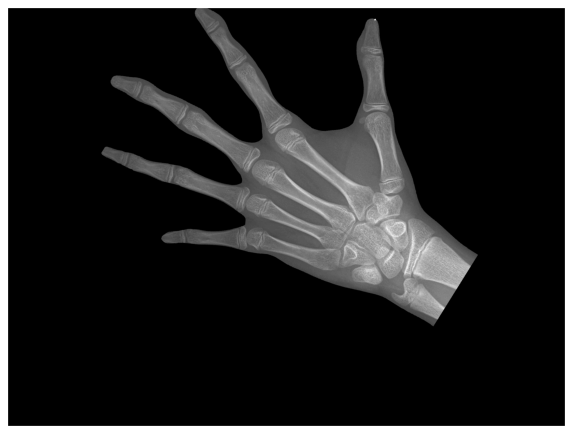

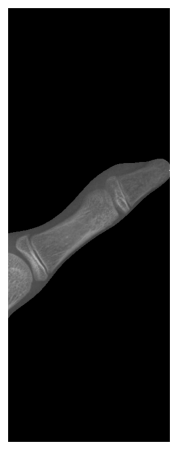

349
486
154
557


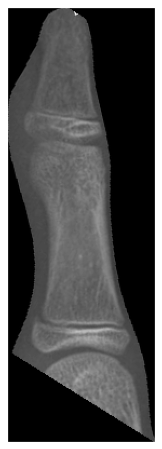

In [154]:
img = get_img(list_file[2])[0]
center_mask, black_back = img_preprocessing(img)
show(black_back)

far_list = get_far_list(black_back)
# print(far_list)

thX, thY = get_thumbs_point(far_list)
cv2.circle(black_back,(thX, thY), 1, (255,0,255),4)
show(black_back)
img=thumbs_rotation(black_back)
show(img)
img = rotation_cut(img)
show(img)
imgY, imgX = get_center(img)
thumbs = thumbs_cut(black_back)
show(thumbs)
img=thumbs_rotation(thumbs)
thumbs = get_thumbs_croped(img)
show(thumbs)
# #위자르기
# img = rotation_cut(img)
# show(img)
# #아래자르기
# img = rotation_cut_down(img)
# show(img)
# img = rotation_cut_x1(img)
# show(img)
# imgY, imgX = get_center(img)
# cv2.circle(img, (imgY, imgX), 1, (200, 0,255),5)
# show(img)

In [156]:
def get_thumbs_croped(img):
    ret, thresh = cv2.threshold(img, thumbs.mean(), 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_xy = np.array(contours)

    # x의 min과 max 찾기
    x_min, x_max = 0,0
    value = list()
    for i in range(len(contours_xy)):
        for j in range(len(contours_xy[i])):
            value.append(contours_xy[i][j][0][0]) #네번째 괄호가 0일때 x의 값
            x_min = min(value)
            x_max = max(value)
#     print(x_min)
#     print(x_max)

    # y의 min과 max 찾기
    y_min, y_max = 0,0
    value = list()
    for i in range(len(contours_xy)):
        for j in range(len(contours_xy[i])):
            value.append(contours_xy[i][j][0][1]) #네번째 괄호가 0일때 x의 값
            y_min = min(value)
            y_max = max(value)
#     print(y_min)
#     print(y_max)

    # image trim 하기
    x = x_min
    y = y_min
    w = x_max-x_min
    h = y_max-y_min

    img_trim = img[y:y+h, x:x+w]
    
    return img_trim 


349
486
154
557


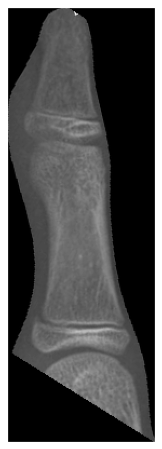

In [148]:
ret, thresh = cv2.threshold(img, thumbs.mean(), 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_xy = np.array(contours)

# x의 min과 max 찾기
x_min, x_max = 0,0
value = list()
for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
        value.append(contours_xy[i][j][0][0]) #네번째 괄호가 0일때 x의 값
        x_min = min(value)
        x_max = max(value)
print(x_min)
print(x_max)
 
# y의 min과 max 찾기
y_min, y_max = 0,0
value = list()
for i in range(len(contours_xy)):
    for j in range(len(contours_xy[i])):
        value.append(contours_xy[i][j][0][1]) #네번째 괄호가 0일때 x의 값
        y_min = min(value)
        y_max = max(value)
print(y_min)
print(y_max)

# image trim 하기
x = x_min
y = y_min
w = x_max-x_min
h = y_max-y_min

img_trim = img[y:y+h, x:x+w]

show(img_trim)

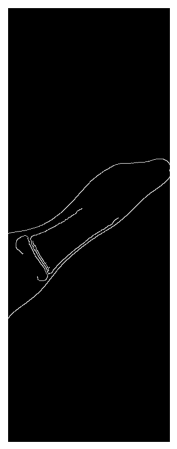

In [139]:
blur = cv2.GaussianBlur(thumbs, ksize=(3,3), sigmaX=0)
ret, thresh1 = cv2.threshold(blur, thumbs.mean(), 255, cv2.THRESH_BINARY)
edged = cv2.Canny(blur, thumbs.mean(),250)
show(edged)

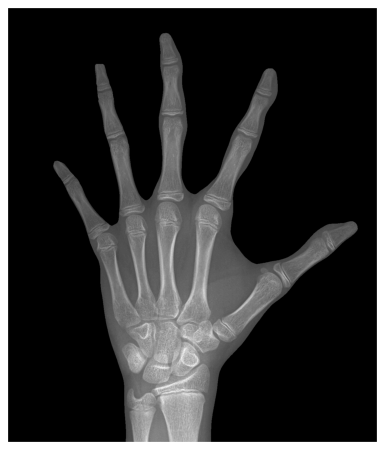

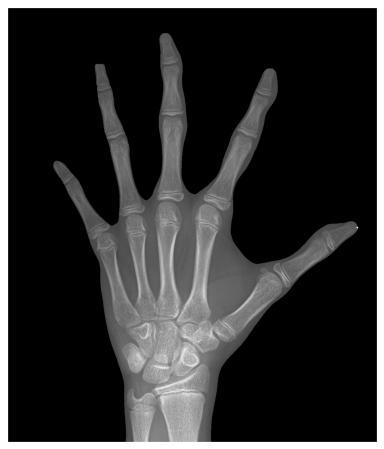

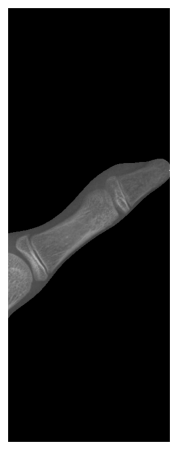

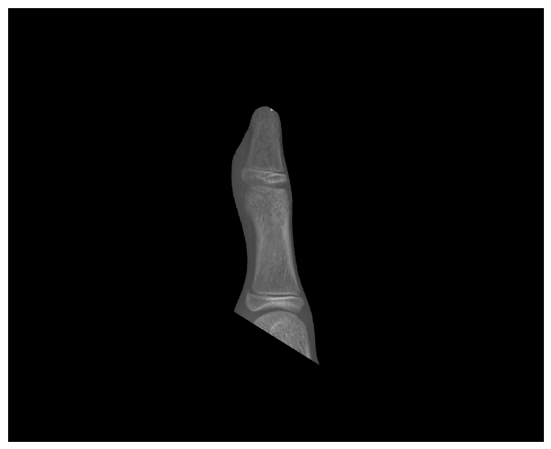

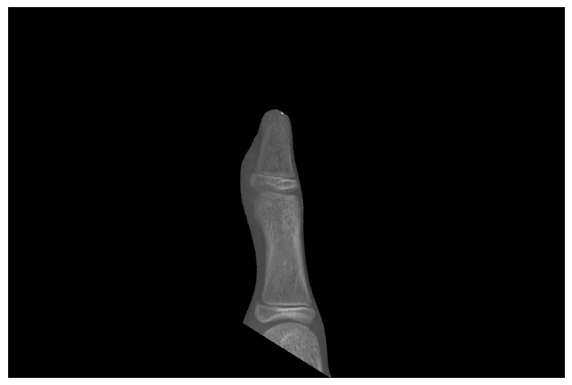

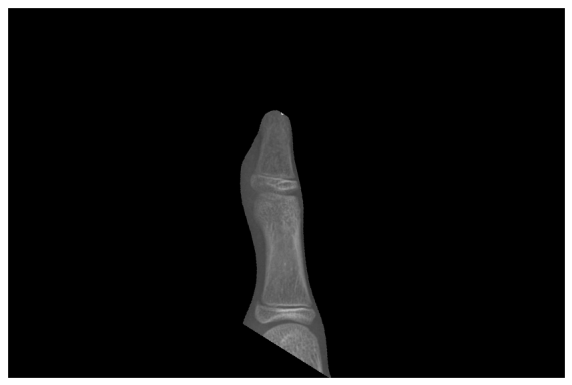

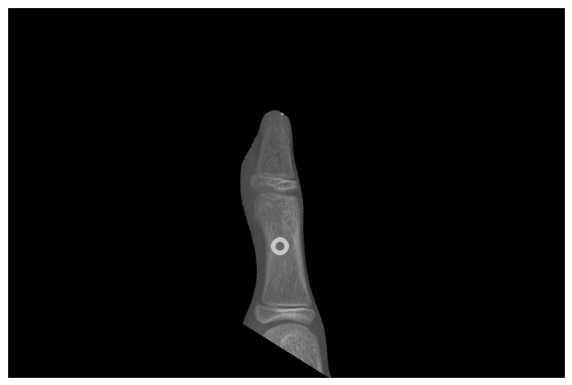

In [98]:
img = get_img(list_file[2])[0]
center_mask, black_back = img_preprocessing(img)
show(black_back)

far_list = get_far_list(black_back)
# print(far_list)

thX, thY = get_thumbs_point(far_list)
cv2.circle(black_back,(thX, thY), 1, (255,0,255),4)
show(black_back)
# img=thumbs_rotation(black_back)
# show(img)
# img = rotation_cut(img)
# show(img)
# imgY, imgX = get_center(img)
thumbs = thumbs_cut(black_back)
show(thumbs)
img=thumbs_rotation(thumbs)
show(img)
#위자르기
img = rotation_cut(img)
show(img)
#아래자르기
img = rotation_cut_down(img)
show(img)
img = rotation_cut_x1(img)
show(img)
imgY, imgX = get_center(img)
cv2.circle(img, (imgY, imgX), 10, (200, 0,255),5)
show(img)

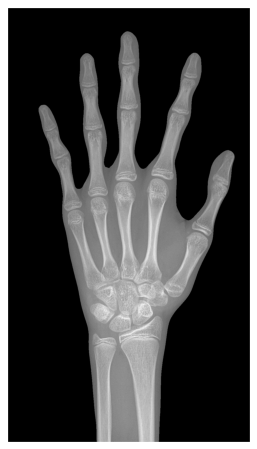

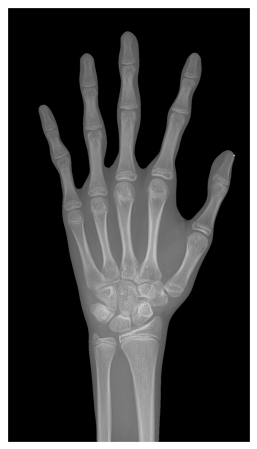

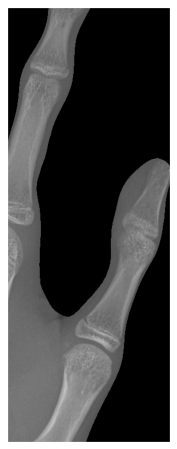

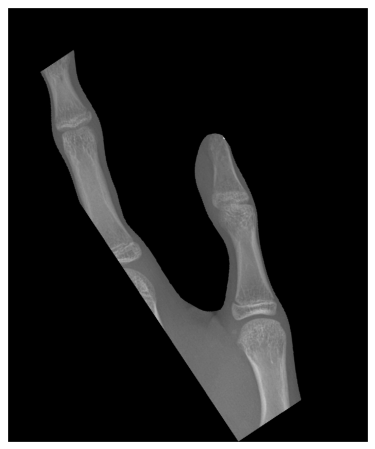

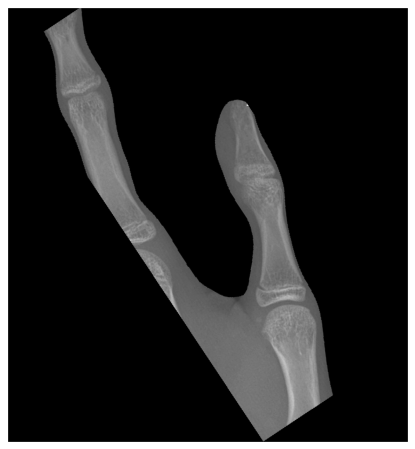

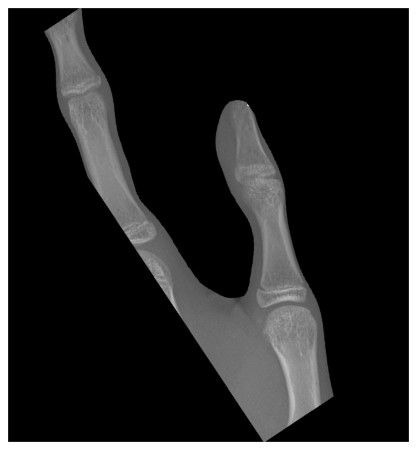

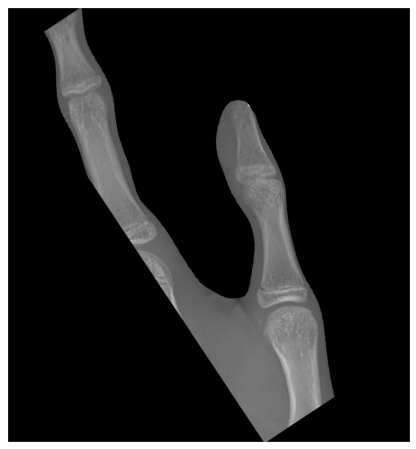

In [96]:
img = get_img(list_file[2])[8]
center_mask, black_back = img_preprocessing(img)
show(black_back)

far_list = get_far_list(black_back)
# print(far_list)

thX, thY = get_thumbs_point(far_list)
cv2.circle(black_back,(thX, thY), 1, (255,0,255),4)
show(black_back)
# img=thumbs_rotation(black_back)
# show(img)
# img = rotation_cut(img)
# show(img)
# imgY, imgX = get_center(img)
thumbs = thumbs_cut(black_back)
show(thumbs)
img=thumbs_rotation(thumbs)
show(img)
img = rotation_cut(img)
show(img)

img = rotation_cut_down(img)
show(img)
img = rotation_cut_x1(img)
show(img)

### extraction

In [181]:
#warnings
import warnings
warnings.filterwarnings('ignore')

In [176]:
list_file

['/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_10yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_11yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_12yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_13yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_14yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_15yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_16yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_3yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_4yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_F_5yr',
 '/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_

In [184]:
img_path = os.path.join(list_file[0],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img=get_img(list_file[0])[i]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_10yr_thumbs/thumbs_10_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'번쨰 오류')
        break
        

['320_F', '358_F', '339_F', '341_F', '343_F', '322_F', '326_F', '347_F', '345_F', '324_F', '319_F', '342_F', '323_F', '359_F', '321_F', '340_F', '338_F', '344_F', '318_F', '325_F', '327_F', '346_F', '332_F', '316_F', '353_F', '329_F', '314_F', '351_F', '330_F', '348_F', '334_F', '310_F', '355_F', '312_F', '357_F', '336_F', '350_F', '315_F', '328_F', '349_F', '331_F', '333_F', '352_F', '317_F', '356_F', '313_F', '337_F', '335_F', '354_F', '311_F']
1째 완료
2째 완료
3째 완료
4째 완료
5째 완료
6째 완료
7째 완료
8째 완료
9째 완료
10째 완료
11째 완료
12째 완료
13째 완료
14째 완료
15째 완료
16째 완료
17째 완료
18째 완료
19째 완료
20째 완료
21째 완료
22째 완료
23째 완료
24째 완료
25째 완료
26째 완료
27째 완료
28째 완료
29째 완료
30째 완료
31째 완료
32째 완료
33째 완료
34째 완료
35째 완료
36째 완료
37째 완료
38째 완료
39째 완료
40째 완료


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [185]:
img_path = os.path.join(list_file[0],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img=get_img(list_file[0])[i+41]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_10yr_thumbs/thumbs_10_{}.jpg'.format(img_number_list[i+41])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}째 완료'.format(i+42))
    except IndexError as e:
        print('끝', i+42,'번쨰 오류')
        break
        

['320_F', '358_F', '339_F', '341_F', '343_F', '322_F', '326_F', '347_F', '345_F', '324_F', '319_F', '342_F', '323_F', '359_F', '321_F', '340_F', '338_F', '344_F', '318_F', '325_F', '327_F', '346_F', '332_F', '316_F', '353_F', '329_F', '314_F', '351_F', '330_F', '348_F', '334_F', '310_F', '355_F', '312_F', '357_F', '336_F', '350_F', '315_F', '328_F', '349_F', '331_F', '333_F', '352_F', '317_F', '356_F', '313_F', '337_F', '335_F', '354_F', '311_F']
42째 완료
43째 완료
44째 완료
45째 완료
46째 완료
47째 완료
48째 완료
49째 완료


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [189]:
img_path = os.path.join(list_file[0],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img=get_img(list_file[0])[i+50]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_10yr_thumbs/thumbs_10_{}.jpg'.format(img_number_list[i+50])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}째 완료'.format(i+51))
    except IndexError as e:
        print('끝', i+51,'번쨰 오류')
        break
        

['320_F', '358_F', '339_F', '341_F', '343_F', '322_F', '326_F', '347_F', '345_F', '324_F', '319_F', '342_F', '323_F', '359_F', '321_F', '340_F', '338_F', '344_F', '318_F', '325_F', '327_F', '346_F', '332_F', '316_F', '353_F', '329_F', '314_F', '351_F', '330_F', '348_F', '334_F', '310_F', '355_F', '312_F', '357_F', '336_F', '350_F', '315_F', '328_F', '349_F', '331_F', '333_F', '352_F', '317_F', '356_F', '313_F', '337_F', '335_F', '354_F', '311_F']
끝 51 번쨰 오류


In [177]:
img_path = os.path.join(list_file[1],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img=get_img(list_file[1])[i]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_11yr_thumbs/thumbs_11_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'번쨰 오류')
        break
        

['398_F', '365_F', '381_F', '383_F', '367_F', '363_F', '387_F', '378_F', '385_F', '409_F', '361_F', '382_F', '366_F', '399_F', '364_F', '380_F', '379_F', '384_F', '408_F', '360_F', '362_F', '386_F', '377_F', '393_F', '406_F', '404_F', '391_F', '375_F', '388_F', '371_F', '395_F', '368_F', '400_F', '402_F', '397_F', '373_F', '405_F', '390_F', '374_F', '389_F', '376_F', '392_F', '407_F', '403_F', '396_F', '372_F', '370_F', '394_F', '369_F', '401_F']


<ipython-input-170-fad878baaf73>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


1째 완료
2째 완료
3째 완료
4째 완료
5째 완료
6째 완료


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [180]:
img_path = os.path.join(list_file[1],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img=get_img(list_file[1])[i+7]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_11yr_thumbs/thumbs_11_{}.jpg'.format(img_number_list[i+7])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}째 완료'.format(i+8))
    except IndexError as e:
        print('끝', i+8,'번쨰 오류')
        break
        

['398_F', '365_F', '381_F', '383_F', '367_F', '363_F', '387_F', '378_F', '385_F', '409_F', '361_F', '382_F', '366_F', '399_F', '364_F', '380_F', '379_F', '384_F', '408_F', '360_F', '362_F', '386_F', '377_F', '393_F', '406_F', '404_F', '391_F', '375_F', '388_F', '371_F', '395_F', '368_F', '400_F', '402_F', '397_F', '373_F', '405_F', '390_F', '374_F', '389_F', '376_F', '392_F', '407_F', '403_F', '396_F', '372_F', '370_F', '394_F', '369_F', '401_F']
8째 완료
9째 완료
10째 완료
11째 완료
12째 완료
13째 완료
14째 완료
15째 완료


<ipython-input-170-fad878baaf73>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours_xy = np.array(contours)


16째 완료
17째 완료
18째 완료
19째 완료
20째 완료
21째 완료
22째 완료
23째 완료
24째 완료
25째 완료
26째 완료
27째 완료
28째 완료
29째 완료
30째 완료
31째 완료
32째 완료
33째 완료
34째 완료
35째 완료
36째 완료
37째 완료
38째 완료
39째 완료
40째 완료
41째 완료
42째 완료
43째 완료
44째 완료
45째 완료
46째 완료


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [182]:
img_path = os.path.join(list_file[1],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img=get_img(list_file[1])[i+48]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_11yr_thumbs/thumbs_11_{}.jpg'.format(img_number_list[i+48])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}째 완료'.format(i+49))
    except IndexError as e:
        print('끝', i+49,'번쨰 오류')
        break
        

['398_F', '365_F', '381_F', '383_F', '367_F', '363_F', '387_F', '378_F', '385_F', '409_F', '361_F', '382_F', '366_F', '399_F', '364_F', '380_F', '379_F', '384_F', '408_F', '360_F', '362_F', '386_F', '377_F', '393_F', '406_F', '404_F', '391_F', '375_F', '388_F', '371_F', '395_F', '368_F', '400_F', '402_F', '397_F', '373_F', '405_F', '390_F', '374_F', '389_F', '376_F', '392_F', '407_F', '403_F', '396_F', '372_F', '370_F', '394_F', '369_F', '401_F']
49째 완료
50째 완료
끝 51 번쨰 오류


In [190]:
img_path = os.path.join(list_file[2],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img=get_img(list_file[2])[i]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_12yr_thumbs/thumbs_12_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'번쨰 오류')
        break
        

['448_F', '430_F', '414_F', '451_F', '429_F', '416_F', '453_F', '432_F', '436_F', '412_F', '457_F', '410_F', '455_F', '434_F', '452_F', '417_F', '433_F', '431_F', '449_F', '428_F', '450_F', '415_F', '454_F', '411_F', '435_F', '437_F', '456_F', '413_F', '422_F', '443_F', '441_F', '439_F', '458_F', '420_F', '419_F', '424_F', '445_F', '447_F', '426_F', '438_F', '440_F', '421_F', '459_F', '423_F', '442_F', '446_F', '427_F', '425_F', '418_F', '444_F']
1째 완료
2째 완료
3째 완료
4째 완료
5째 완료
6째 완료
7째 완료
8째 완료
9째 완료
10째 완료
11째 완료
12째 완료
13째 완료


KeyboardInterrupt: 

In [191]:
img_path = os.path.join(list_file[3],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img=get_img(list_file[3])[i]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_13yr_thumbs/thumbs_13_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'번쨰 오류')
        break
        

['475_F', '488_F', '491_F', '493_F', '477_F', '473_F', '497_F', '495_F', '468_F', '471_F', '492_F', '476_F', '474_F', '489_F', '490_F', '494_F', '469_F', '470_F', '472_F', '496_F', '467_F', '502_F', '483_F', '481_F', '500_F', '498_F', '465_F', '504_F', '461_F', '478_F', '485_F', '487_F', '463_F', '480_F', '499_F', '464_F', '501_F', '503_F', '466_F', '482_F', '486_F', '462_F', '460_F', '479_F', '484_F']
1째 완료
2째 완료
3째 완료
4째 완료
5째 완료
6째 완료
7째 완료
8째 완료
9째 완료
10째 완료
11째 완료
12째 완료
13째 완료
14째 완료
15째 완료
16째 완료
17째 완료
18째 완료


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [192]:
img_path = os.path.join(list_file[3],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img=get_img(list_file[3])[i+20]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_13yr_thumbs/thumbs_13_{}.jpg'.format(img_number_list[i+20])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}째 완료'.format(i+21))
    except IndexError as e:
        print('끝', i+21,'번쨰 오류')
        break
        

['475_F', '488_F', '491_F', '493_F', '477_F', '473_F', '497_F', '495_F', '468_F', '471_F', '492_F', '476_F', '474_F', '489_F', '490_F', '494_F', '469_F', '470_F', '472_F', '496_F', '467_F', '502_F', '483_F', '481_F', '500_F', '498_F', '465_F', '504_F', '461_F', '478_F', '485_F', '487_F', '463_F', '480_F', '499_F', '464_F', '501_F', '503_F', '466_F', '482_F', '486_F', '462_F', '460_F', '479_F', '484_F']
21째 완료
22째 완료
23째 완료
24째 완료
25째 완료
26째 완료
27째 완료
28째 완료
29째 완료
30째 완료
31째 완료
32째 완료
33째 완료
34째 완료
35째 완료
36째 완료
37째 완료
38째 완료
39째 완료
40째 완료
41째 완료
42째 완료
43째 완료
44째 완료
45째 완료
끝 46 번쨰 오류


In [193]:
img_path = os.path.join(list_file[4],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)

for i in range(100):
    try:
        img=get_img(list_file[4])[i]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_14yr_thumbs/thumbs_14_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}째 완료'.format(i+21))
    except IndexError as e:
        print('끝', i+21,'번쨰 오류')
        break
        

['510_F', '509_F', '534_F', '536_F', '512_F', '516_F', '532_F', '530_F', '514_F', '529_F', '537_F', '513_F', '511_F', '535_F', '508_F', '531_F', '528_F', '515_F', '517_F', '533_F', '526_F', '519_F', '524_F', '539_F', '520_F', '522_F', '506_F', '525_F', '518_F', '527_F', '523_F', '507_F', '538_F', '505_F', '540_F', '521_F']
21째 완료
22째 완료
23째 완료
24째 완료
25째 완료
26째 완료
27째 완료
28째 완료
29째 완료
30째 완료
31째 완료
32째 완료
33째 완료
34째 완료
35째 완료
36째 완료
37째 완료
38째 완료
39째 완료
40째 완료
41째 완료
42째 완료
43째 완료
44째 완료
45째 완료
46째 완료
47째 완료
48째 완료
49째 완료
50째 완료
51째 완료
52째 완료
53째 완료
54째 완료
55째 완료
56째 완료
끝 57 번쨰 오류


In [194]:
img_path = os.path.join(list_file[5],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[5])[i]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_15yr_thumbs/thumbs_15_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

['555_F', '557_F', '553_F', '548_F', '551_F', '556_F', '554_F', '549_F', '550_F', '552_F', '547_F', '545_F', '541_F', '558_F', '543_F', '544_F', '546_F', '542_F', '559_F']
19
1째 완료
2째 완료
3째 완료
4째 완료
5째 완료
6째 완료
7째 완료
8째 완료
9째 완료
10째 완료
11째 완료
12째 완료
13째 완료
14째 완료
15째 완료
16째 완료
17째 완료
18째 완료
19째 완료
끝 20 개


In [195]:
img_path = os.path.join(list_file[6],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[6])[i]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_16yr_thumbs/thumbs_16_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

['568_F', '571_F', '569_F', '570_F', '563_F', '561_F', '565_F', '567_F', '560_F', '562_F', '566_F', '564_F']
13 개
1째 완료
2째 완료
3째 완료
4째 완료
5째 완료
6째 완료
7째 완료
8째 완료
9째 완료
10째 완료
11째 완료
12째 완료
끝 13 개


In [196]:
img_path = os.path.join(list_file[7],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[7])[i]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_F_3yr_thumbs/thumbs_3_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

['8_F', '16_F', '14_F', '10_F', '12_F', '15_F', '17_F', '9_F', '13_F', '11_F', '3_F', '1_F', '5_F', '19_F', '7_F', '2_F', '6_F', '18_F', '4_F']
20 개


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [199]:
list_file[14]

'/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_10yr'

In [200]:
#애기손가락 새로운 코드 필요
list_file[14]
img_path = os.path.join(list_file[14],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[14])[i]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_10yr_thumbs/thumbs_10_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

['352_M', '376_M', '333_M', '374_M', '349_M', '350_M', '369_M', '354_M', '370_M', '335_M', '372_M', '337_M', '356_M', '348_M', '375_M', '351_M', '353_M', '332_M', '377_M', '336_M', '373_M', '357_M', '355_M', '368_M', '334_M', '371_M', '338_M', '380_M', '340_M', '364_M', '359_M', '366_M', '342_M', '346_M', '362_M', '360_M', '379_M', '344_M', '367_M', '343_M', '341_M', '339_M', '381_M', '358_M', '365_M', '361_M', '345_M', '378_M', '347_M', '363_M']
51 개
1번째 완료


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [201]:
list_file[14]
img_path = os.path.join(list_file[14],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[14])[i+3]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_10yr_thumbs/thumbs_10_{}.jpg'.format(img_number_list[i+3])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}번째 완료'.format(i+4))
    except IndexError as e:
        print('끝', i+4,'개')
        break
        

['352_M', '376_M', '333_M', '374_M', '349_M', '350_M', '369_M', '354_M', '370_M', '335_M', '372_M', '337_M', '356_M', '348_M', '375_M', '351_M', '353_M', '332_M', '377_M', '336_M', '373_M', '357_M', '355_M', '368_M', '334_M', '371_M', '338_M', '380_M', '340_M', '364_M', '359_M', '366_M', '342_M', '346_M', '362_M', '360_M', '379_M', '344_M', '367_M', '343_M', '341_M', '339_M', '381_M', '358_M', '365_M', '361_M', '345_M', '378_M', '347_M', '363_M']
51 개
4번째 완료
5번째 완료
6번째 완료


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [202]:
list_file[14]
img_path = os.path.join(list_file[14],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[14])[i+8]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_10yr_thumbs/thumbs_10_{}.jpg'.format(img_number_list[i+8])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}번째 완료'.format(i+9))
    except IndexError as e:
        print('끝', i+9,'개')
        break
        

['352_M', '376_M', '333_M', '374_M', '349_M', '350_M', '369_M', '354_M', '370_M', '335_M', '372_M', '337_M', '356_M', '348_M', '375_M', '351_M', '353_M', '332_M', '377_M', '336_M', '373_M', '357_M', '355_M', '368_M', '334_M', '371_M', '338_M', '380_M', '340_M', '364_M', '359_M', '366_M', '342_M', '346_M', '362_M', '360_M', '379_M', '344_M', '367_M', '343_M', '341_M', '339_M', '381_M', '358_M', '365_M', '361_M', '345_M', '378_M', '347_M', '363_M']
51 개
9번째 완료
10번째 완료
11번째 완료
12번째 완료
13번째 완료
14번째 완료
15번째 완료
16번째 완료
17번째 완료
18번째 완료
19번째 완료
20번째 완료
21번째 완료
22번째 완료
23번째 완료
24번째 완료
25번째 완료
26번째 완료
27번째 완료
28번째 완료
29번째 완료
30번째 완료
31번째 완료
32번째 완료
33번째 완료
34번째 완료
35번째 완료
36번째 완료
37번째 완료
38번째 완료
39번째 완료


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [203]:
list_file[14]
img_path = os.path.join(list_file[14],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[14])[i+41]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_10yr_thumbs/thumbs_10_{}.jpg'.format(img_number_list[i+41])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}번 완료'.format(img_number_list[i+41]))
    except IndexError as e:
        print('끝', i+9,'개')
        break
        

['352_M', '376_M', '333_M', '374_M', '349_M', '350_M', '369_M', '354_M', '370_M', '335_M', '372_M', '337_M', '356_M', '348_M', '375_M', '351_M', '353_M', '332_M', '377_M', '336_M', '373_M', '357_M', '355_M', '368_M', '334_M', '371_M', '338_M', '380_M', '340_M', '364_M', '359_M', '366_M', '342_M', '346_M', '362_M', '360_M', '379_M', '344_M', '367_M', '343_M', '341_M', '339_M', '381_M', '358_M', '365_M', '361_M', '345_M', '378_M', '347_M', '363_M']
51 개
339_M번째 완료


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [204]:
print(list_file[14])
img_path = os.path.join(list_file[14],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[14])[i+43]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_10yr_thumbs/thumbs_10_{}.jpg'.format(img_number_list[i+43])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i+43]),'{}개 완료'.format(i+44))
    except IndexError as e:
        print('끝', i+44,'개')
        break
        

['352_M', '376_M', '333_M', '374_M', '349_M', '350_M', '369_M', '354_M', '370_M', '335_M', '372_M', '337_M', '356_M', '348_M', '375_M', '351_M', '353_M', '332_M', '377_M', '336_M', '373_M', '357_M', '355_M', '368_M', '334_M', '371_M', '338_M', '380_M', '340_M', '364_M', '359_M', '366_M', '342_M', '346_M', '362_M', '360_M', '379_M', '344_M', '367_M', '343_M', '341_M', '339_M', '381_M', '358_M', '365_M', '361_M', '345_M', '378_M', '347_M', '363_M']
51 개
358_M완료 44
365_M완료 45
361_M완료 46
345_M완료 47
378_M완료 48
347_M완료 49
363_M완료 50
끝 51 개


In [205]:
print(list_file[15])
img_path = os.path.join(list_file[15],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[15])[i]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_11yr_thumbs/thumbs_11_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}개 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_11yr
['407_M', '392_M', '423_M', '389_M', '421_M', '390_M', '405_M', '401_M', '394_M', '418_M', '425_M', '427_M', '396_M', '403_M', '420_M', '388_M', '391_M', '404_M', '406_M', '393_M', '422_M', '426_M', '397_M', '402_M', '400_M', '395_M', '424_M', '419_M', '415_M', '428_M', '399_M', '431_M', '382_M', '417_M', '413_M', '386_M', '408_M', '384_M', '411_M', '383_M', '416_M', '429_M', '414_M', '430_M', '398_M', '409_M', '385_M', '410_M', '412_M', '387_M']
51 개
407_M완료 1개 완료
392_M완료 2개 완료
423_M완료 3개 완료
389_M완료 4개 완료
421_M완료 5개 완료
390_M완료 6개 완료
405_M완료 7개 완료
401_M완료 8개 완료
394_M완료 9개 완료
418_M완료 10개 완료
425_M완료 11개 완료
427_M완료 12개 완료
396_M완료 13개 완료
403_M완료 14개 완료


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [207]:
print(list_file[15])
img_path = os.path.join(list_file[15],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[15])[i+15]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_11yr_thumbs/thumbs_11_{}.jpg'.format(img_number_list[i+15])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i+15]),'{}번째 완료'.format(i+16))
    except IndexError as e:
        print('끝', i+16,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_11yr
['407_M', '392_M', '423_M', '389_M', '421_M', '390_M', '405_M', '401_M', '394_M', '418_M', '425_M', '427_M', '396_M', '403_M', '420_M', '388_M', '391_M', '404_M', '406_M', '393_M', '422_M', '426_M', '397_M', '402_M', '400_M', '395_M', '424_M', '419_M', '415_M', '428_M', '399_M', '431_M', '382_M', '417_M', '413_M', '386_M', '408_M', '384_M', '411_M', '383_M', '416_M', '429_M', '414_M', '430_M', '398_M', '409_M', '385_M', '410_M', '412_M', '387_M']
51 개
388_M완료 16개 완료
391_M완료 17개 완료
404_M완료 18개 완료
406_M완료 19개 완료
393_M완료 20개 완료


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [208]:
print(list_file[15])
img_path = os.path.join(list_file[15],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[15])[i+21]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_11yr_thumbs/thumbs_11_{}.jpg'.format(img_number_list[i+21])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i+21]),'{}번째 완료'.format(i+22))
    except IndexError as e:
        print('끝', i+22,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_11yr
['407_M', '392_M', '423_M', '389_M', '421_M', '390_M', '405_M', '401_M', '394_M', '418_M', '425_M', '427_M', '396_M', '403_M', '420_M', '388_M', '391_M', '404_M', '406_M', '393_M', '422_M', '426_M', '397_M', '402_M', '400_M', '395_M', '424_M', '419_M', '415_M', '428_M', '399_M', '431_M', '382_M', '417_M', '413_M', '386_M', '408_M', '384_M', '411_M', '383_M', '416_M', '429_M', '414_M', '430_M', '398_M', '409_M', '385_M', '410_M', '412_M', '387_M']
51 개
426_M완료 22번째 완료
397_M완료 23번째 완료
402_M완료 24번째 완료
400_M완료 25번째 완료
395_M완료 26번째 완료
424_M완료 27번째 완료
419_M완료 28번째 완료
415_M완료 29번째 완료
428_M완료 30번째 완료
399_M완료 31번째 완료
431_M완료 32번째 완료
382_M완료 33번째 완료
417_M완료 34번째 완료
413_M완료 35번째 완료
386_M완료 36번째 완료
408_M완료 37번째 완료
384_M완료 38번째 완료
411_M완료 39번째 완료
383_M완료 40번째 완료
416_M완료 41번째 완료
429_M완료 42번째 완료
414_M완료 43번째 완료
430_M완료 44번째 완료
398_M완료 45번째 완료
409_M완료 46번째 완료
385_M완료 47번째 완료
410_M완료 48번째 완료
412_M완료 49번째 완료
387_M완료 

In [209]:
print(list_file[16])
img_path = os.path.join(list_file[16],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[16])[i]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_12yr_thumbs/thumbs_12_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_12yr
['442_M', '466_M', '459_M', '464_M', '440_M', '438_M', '480_M', '444_M', '479_M', '460_M', '462_M', '446_M', '465_M', '458_M', '439_M', '481_M', '441_M', '443_M', '467_M', '463_M', '447_M', '478_M', '445_M', '461_M', '450_M', '449_M', '474_M', '476_M', '433_M', '452_M', '456_M', '472_M', '437_M', '470_M', '435_M', '454_M', '469_M', '432_M', '477_M', '453_M', '451_M', '475_M', '448_M', '434_M', '471_M', '468_M', '455_M', '457_M', '436_M', '473_M']
51 개
442_M완료 1번째 완료
466_M완료 2번째 완료
459_M완료 3번째 완료
464_M완료 4번째 완료
440_M완료 5번째 완료
438_M완료 6번째 완료
480_M완료 7번째 완료
444_M완료 8번째 완료
479_M완료 9번째 완료
460_M완료 10번째 완료
462_M완료 11번째 완료
446_M완료 12번째 완료
465_M완료 13번째 완료
458_M완료 14번째 완료
439_M완료 15번째 완료
481_M완료 16번째 완료


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [210]:
print(list_file[16])
img_path = os.path.join(list_file[16],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[16])[i+17]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_12yr_thumbs/thumbs_12_{}.jpg'.format(img_number_list[i+17])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i+17]),'{}번째 완료'.format(i+18))
    except IndexError as e:
        print('끝', i+18,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_12yr
['442_M', '466_M', '459_M', '464_M', '440_M', '438_M', '480_M', '444_M', '479_M', '460_M', '462_M', '446_M', '465_M', '458_M', '439_M', '481_M', '441_M', '443_M', '467_M', '463_M', '447_M', '478_M', '445_M', '461_M', '450_M', '449_M', '474_M', '476_M', '433_M', '452_M', '456_M', '472_M', '437_M', '470_M', '435_M', '454_M', '469_M', '432_M', '477_M', '453_M', '451_M', '475_M', '448_M', '434_M', '471_M', '468_M', '455_M', '457_M', '436_M', '473_M']
51 개
443_M완료 18번째 완료
467_M완료 19번째 완료
463_M완료 20번째 완료


error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [211]:
print(list_file[16])
img_path = os.path.join(list_file[16],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[16])[i+21]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_12yr_thumbs/thumbs_12_{}.jpg'.format(img_number_list[i+21])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i+21]),'{}번째 완료'.format(i+22))
    except IndexError as e:
        print('끝', i+22,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_12yr
['442_M', '466_M', '459_M', '464_M', '440_M', '438_M', '480_M', '444_M', '479_M', '460_M', '462_M', '446_M', '465_M', '458_M', '439_M', '481_M', '441_M', '443_M', '467_M', '463_M', '447_M', '478_M', '445_M', '461_M', '450_M', '449_M', '474_M', '476_M', '433_M', '452_M', '456_M', '472_M', '437_M', '470_M', '435_M', '454_M', '469_M', '432_M', '477_M', '453_M', '451_M', '475_M', '448_M', '434_M', '471_M', '468_M', '455_M', '457_M', '436_M', '473_M']
51 개
478_M완료 22번째 완료
445_M완료 23번째 완료
461_M완료 24번째 완료
450_M완료 25번째 완료
449_M완료 26번째 완료
474_M완료 27번째 완료
476_M완료 28번째 완료
433_M완료 29번째 완료
452_M완료 30번째 완료
456_M완료 31번째 완료
472_M완료 32번째 완료
437_M완료 33번째 완료
470_M완료 34번째 완료
435_M완료 35번째 완료
454_M완료 36번째 완료
469_M완료 37번째 완료
432_M완료 38번째 완료
477_M완료 39번째 완료
453_M완료 40번째 완료
451_M완료 41번째 완료
475_M완료 42번째 완료
448_M완료 43번째 완료
434_M완료 44번째 완료
471_M완료 45번째 완료
468_M완료 46번째 완료
455_M완료 47번째 완료
457_M완료 48번째 완료
436_M완료 49번째 완료
473_M완료 

In [212]:
print(list_file[17])
img_path = os.path.join(list_file[17],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[17])[i]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_13yr_thumbs/thumbs_13_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_13yr
['482_M', '527_M', '503_M', '501_M', '499_M', '518_M', '525_M', '521_M', '484_M', '505_M', '507_M', '523_M', '486_M', '498_M', '500_M', '524_M', '519_M', '526_M', '483_M', '502_M', '506_M', '487_M', '522_M', '485_M', '520_M', '504_M', '508_M', '490_M', '511_M', '489_M', '513_M', '492_M', '496_M', '517_M', '515_M', '528_M', '494_M', '531_M', '512_M', '493_M', '491_M', '509_M', '488_M', '510_M', '529_M', '514_M', '530_M', '495_M', '497_M', '516_M']
51 개
482_M완료 1번째 완료
527_M완료 2번째 완료
503_M완료 3번째 완료
501_M완료 4번째 완료
499_M완료 5번째 완료
518_M완료 6번째 완료
525_M완료 7번째 완료
521_M완료 8번째 완료
484_M완료 9번째 완료
505_M완료 10번째 완료
507_M완료 11번째 완료
523_M완료 12번째 완료
486_M완료 13번째 완료
498_M완료 14번째 완료
500_M완료 15번째 완료
524_M완료 16번째 완료
519_M완료 17번째 완료
526_M완료 18번째 완료
483_M완료 19번째 완료
502_M완료 20번째 완료
506_M완료 21번째 완료
487_M완료 22번째 완료
522_M완료 23번째 완료
485_M완료 24번째 완료
520_M완료 25번째 완료
504_M완료 26번째 완료
508_M완료 27번째 완료
490_M완료 28번째 완료
511_M완료 29번째 완료
4

In [213]:
print(list_file[18])
img_path = os.path.join(list_file[18],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[18])[i]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_14yr_thumbs/thumbs_14_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_14yr
['562_M', '546_M', '544_M', '579_M', '560_M', '559_M', '564_M', '540_M', '538_M', '580_M', '542_M', '566_M', '578_M', '545_M', '561_M', '563_M', '547_M', '543_M', '567_M', '565_M', '558_M', '539_M', '581_M', '541_M', '535_M', '570_M', '554_M', '569_M', '556_M', '537_M', '572_M', '533_M', '576_M', '552_M', '550_M', '549_M', '574_M', '557_M', '573_M', '536_M', '571_M', '534_M', '568_M', '555_M', '551_M', '575_M', '548_M', '577_M', '532_M', '553_M']
51 개
562_M완료 1번째 완료
546_M완료 2번째 완료
544_M완료 3번째 완료
579_M완료 4번째 완료
560_M완료 5번째 완료
559_M완료 6번째 완료
564_M완료 7번째 완료
540_M완료 8번째 완료
538_M완료 9번째 완료
580_M완료 10번째 완료
542_M완료 11번째 완료
566_M완료 12번째 완료
578_M완료 13번째 완료
545_M완료 14번째 완료
561_M완료 15번째 완료
563_M완료 16번째 완료
547_M완료 17번째 완료
543_M완료 18번째 완료
567_M완료 19번째 완료
565_M완료 20번째 완료
558_M완료 21번째 완료
539_M완료 22번째 완료
581_M완료 23번째 완료
541_M완료 24번째 완료
535_M완료 25번째 완료
570_M완료 26번째 완료
554_M완료 27번째 완료
569_M완료 28번째 완료
556_M완료 29번째 완료
5

error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/imgcodecs/src/loadsave.cpp:753: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [214]:
print(list_file[18])
img_path = os.path.join(list_file[18],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[18])[i+47]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_14yr_thumbs/thumbs_14_{}.jpg'.format(img_number_list[i+47])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i+47]),'{}번째 완료'.format(i+48))
    except IndexError as e:
        print('끝', i+48,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_14yr
['562_M', '546_M', '544_M', '579_M', '560_M', '559_M', '564_M', '540_M', '538_M', '580_M', '542_M', '566_M', '578_M', '545_M', '561_M', '563_M', '547_M', '543_M', '567_M', '565_M', '558_M', '539_M', '581_M', '541_M', '535_M', '570_M', '554_M', '569_M', '556_M', '537_M', '572_M', '533_M', '576_M', '552_M', '550_M', '549_M', '574_M', '557_M', '573_M', '536_M', '571_M', '534_M', '568_M', '555_M', '551_M', '575_M', '548_M', '577_M', '532_M', '553_M']
51 개
577_M완료 48번째 완료
532_M완료 49번째 완료
553_M완료 50번째 완료
끝 51 개


In [ ]:
print(list_file[19])
img_path = os.path.join(list_file[19],'*g')
img_path = glob.glob(img_path)
img_number_list =[]
for i in range(len(img_path)):
    img_number = img_path[i].split('/')[-1].split('.jpg')[0]
    img_number_list.append(img_number)

print(img_number_list)
print(len(img_number_list)+1, '개')

for i in range(100):
    try:
        img=get_img(list_file[19])[i]
        center_mask, black_back = img_preprocessing(img)
        thX, thY = get_thumbs_point(far_list)
        img=thumbs_rotation(black_back)
        img = rotation_cut(img)
        thumbs = thumbs_cut(black_back)
        thumbs_fin = get_thumbs_croped(thumbs)
        path = "/Users/monica/Documents/프로젝트/Bone Age/Bone_age/Monica's work/thumbs/"
        thumbs_path = path+'BA_M_15yr_thumbs/thumbs_15_{}.jpg'.format(img_number_list[i])
        cv2.imwrite(thumbs_path, thumbs_fin)
        print('{}완료'.format(img_number_list[i]),'{}번째 완료'.format(i+1))
    except IndexError as e:
        print('끝', i+1,'개')
        break
        

/Users/monica/Documents/프로젝트/Bone Age/Bone_age/01_RawData/00_origin/1. 데이터 원본/BA_M_15yr
['626_M', '586_M', '602_M', '600_M', '584_M', '619_M', '624_M', '599_M', '620_M', '604_M', '582_M', '606_M', '622_M', '585_M', '601_M', '625_M', '618_M', '603_M', '587_M', '607_M', '583_M', '623_M', '598_M', '621_M', '605_M', '609_M', '610_M', '594_M', '596_M', '612_M', '592_M', '616_M', '614_M', '590_M', '589_M', '613_M', '597_M', '608_M', '595_M', '611_M', '591_M', '615_M', '588_M', '617_M', '593_M']
46 개
626_M완료 1번째 완료
586_M완료 2번째 완료
602_M완료 3번째 완료
600_M완료 4번째 완료
584_M완료 5번째 완료
